In [41]:
import ast

import matplotlib.pyplot as plt

"""This script will try to apply gaussian process to the Protein-Protein binding affinity data using sklearn GP module first"""
import torch
import esm
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from umap import UMAP
import plotly.express as px
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
%matplotlib inline

In [4]:
# retrieve all proteins from the dataset
df = pd.read_csv('USE__mutant_seqs_WITHscore.csv', index_col=0)
#df = pd.read_csv('skempiwmutants_nanincl.csv', index_col=0)
df = df[['#Pdb','Mutation(s)_PDB', 'Affinity_mut_parsed','Affinity_wt_parsed','Protein 1', 'Protein 2', 'wild_seq1', 'wild_seq2', 'mutant_seq', 'specificity_score']]
df

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein 1,Protein 2,wild_seq1,wild_seq2,mutant_seq,specificity_score
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752
...,...,...,...,...,...,...,...,...,...,...
3411,3QIB_ABP_CD,AA64G,1.540000e-05,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,-1.029619
3412,3QIB_ABP_CD,KA67A,1.430000e-05,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,-0.955511
3413,3QIB_ABP_CD,AA68G,2.290000e-05,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,-1.426389
3414,3QIB_ABP_CD,EA75A,5.500000e-06,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,0.000000


In [5]:
# if there's ":" in the column, just drop first, indicating multi-chain situation
ignore = (df['wild_seq1'].str.contains(':')) | (df['wild_seq2'].str.contains(':')) | (df['mutant_seq'].str.contains(':'))
reduced_df = df[~ignore]
reduced_df

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein 1,Protein 2,wild_seq1,wild_seq2,mutant_seq,specificity_score
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752
...,...,...,...,...,...,...,...,...,...,...
3403,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866
3404,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973
3405,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,0.233872
3406,2WPT_A_B,SB84A,7.090000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.145449


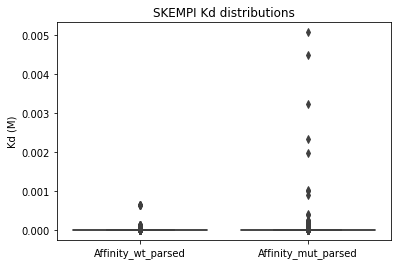

In [7]:
# observe the data first
import seaborn as sns
ax = sns.boxplot(data = reduced_df[['Affinity_wt_parsed', 'Affinity_mut_parsed']])
ax.set(ylabel = 'Kd (M)', title='SKEMPI Kd distributions')
fig = ax.get_figure()
fig.savefig('./outputs/figures/SKEMPI_Kd_distributions.png')
plt.show()

In [8]:
# check and remove if there's any duplicates
reduced_df.drop_duplicates(inplace=True)
df_ = reduced_df.copy()
# shouldn't drop na, na means lose binding ability in mutants
#df_.dropna(inplace=True)
df_['wild_seq_1'] = df_['wild_seq1']
df_['wild_seq_2'] = df_['wild_seq2']
df_['Protein_1'] = df_['Protein 1']
df_['Protein_2'] = df_['Protein 2']
df_ = df_.reset_index(drop=True)
df_

/var/tmp/pbs.810680.hn-10-03/ipykernel_102386/2461256375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df.drop_duplicates(inplace=True)


,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein 1,Protein 2,wild_seq1,wild_seq2,mutant_seq,specificity_score,wild_seq_1,wild_seq_2,Protein_1,Protein_2
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,0.233872,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase
2024,2WPT_A_B,SB84A,7.090000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.145449,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase


In [10]:
"""
    This chunk should re-organize the dataframe so that:
    1. all the sequence listed in wt_seq2 will have positions mutated
    2. if the wt_seq2 and wt_seq1 flipped, so well columns [Protein1, Protein2]
"""
for index, row in df_.iterrows():
    if fuzz.ratio(row['wild_seq1'], row['mutant_seq']) > fuzz.ratio(row['wild_seq2'], row['mutant_seq']) :
        # then the two sequences are similar
        # flip the sequence 1 to sequence 2
            df_.at[index, 'wild_seq_1'] = row['wild_seq2']
            df_.at[index, 'wild_seq_2'] = row['wild_seq1']
            df_.at[index, 'Protein_1'] = row['Protein 2']
            df_.at[index, 'Protein_2'] = row['Protein 1']
    elif fuzz.ratio(row['wild_seq1'], row['mutant_seq'])  < fuzz.ratio(row['wild_seq2'], row['mutant_seq']) :
        pass
    else:
        print(index, fuzz.ratio(row['wild_seq1'], row['mutant_seq']), fuzz.ratio(row['wild_seq2'], row['mutant_seq']))
        print('mutate both sequences?')
df_

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein 1,Protein 2,wild_seq1,wild_seq2,mutant_seq,specificity_score,wild_seq_1,wild_seq_2,Protein_1,Protein_2
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,Subtilisin Carlsberg,Eglin c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,0.233872,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,Colicin E9 DNase,Colicin E2 immunity protein
2024,2WPT_A_B,SB84A,7.090000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.145449,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein,Colicin E9 DNase


In [11]:
df_.drop(columns=['Protein 1', 'Protein 2', 'wild_seq1', 'wild_seq2'], inplace=True)
cols = ['#Pdb', 'Mutation(s)_PDB', 'Affinity_mut_parsed', 'Affinity_wt_parsed','Protein_1',
        'Protein_2','wild_seq_1','wild_seq_2', 'mutant_seq','specificity_score']
df_ = df_[cols]
df_

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752
...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E9 DNase,Colicin E2 immunity protein,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,0.233872
2024,2WPT_A_B,SB84A,7.090000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.145449


In [12]:
# Generate sequence embeddings to the proteins
seqs_wt1 = df_.wild_seq_1.values.tolist()
seqs_wt2 = df_.wild_seq_2.values.tolist()
seqs_mut = df_.mutant_seq.values.tolist()
seqs_wt1 = set(seqs_wt1)
seqs_wt2 = set(seqs_wt2)
seqs_mut = set(seqs_mut)
seqs_mut

{'AGVMTGAKFTQIQFGMTRQQVLDIAGAENCETGGSFGDSIHCRGHAAGDYYAYATFGFTSAAADAKVDSKSQMKLLAPSAPTLTLAKFNQVTVGMTRAQVLATVGQGSCTTWSEYYPAYPSTAGVTLSLSCFDVDGYSSTGFFRGSAHLWFTDGVLQGKRQWDLV',
 'CTCVPPHPQTAFCNSDLVIRAKFVGTPEVNQTTLYQRYEIKMTKMYKGFQALGDAADIRFVYTPAMEAVCGYFHRSHNRSEEFLIAGKLQDGLLHITTCSFVAPWNSLSLAQRRGFTKTYTVGCEE',
 'FPTIPLSRLFDNAMLRAHRLHQLAFDTYQEFEEAYIPKEQKYSFLQNPQTSLCFSESIPTASNREETQQKSNLELLRISLLLIQSWLEPVQFLRSVFANSLVYGASDSNVYDLLKDLEERIQTLMGRLEDGSPRTGQIFKQTYSKFDTNSHNDDALLKNYGLLYCFRKDMDKVETFLRIVQCRSVEGSCGF',
 'MVSLTFKNFKKEKVPLDLEPSNTILETKTKLAQSISCEESQIKLIYSGKVLQDSKTVSECGLKDGDQVVFAVSQKKSTKTKVTERDPNSSSVDKLAAALEHHHHHH',
 'LAAVSVDCSEYPKPQCTLEYRPLCGSDNKTYGNKCNFCNAVVESNGTLTLSHFGKC',
 'AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVAPGKSIGGDIFSNREGKLPGKSGRTWRWADINYTSGFRNSDRILYSSDWLIYKTTDHYQTFTKIR',
 'MELKHSISDYTEAEFLQLVTTICNADTSSEEELVKLVAHFEEMTEHPSGSDLIYYPKEGDDDSPSGIVNTVKQWRAANGKSGFKQG',
 'HKCDITLQEIIKDLNSLTEQKTLCTELTVTDIFAASKNTTEKETFCRAATVLRQFYSHHEKDTRCLGATAQQFHRHKQLIRFLKRLDRNLWGLAGLNSCPVKEANQSTLENFLERLKTIMREK

In [13]:
"""lazy to write function, may need to modify in the future"""
seqs_labeled_wt1 = []
count = 0
for seq in seqs_wt1:
    seqs_labeled_wt1.append(tuple((str('seq' + str(count)), seq)))
    count += 1
seqs_labeled_wt2 = []
count = 0
for seq in seqs_wt2:
    seqs_labeled_wt2.append(tuple((str('seq' + str(count)), seq)))
    count += 1
seqs_labeled_mut = []
count = 0
for seq in seqs_mut:
    seqs_labeled_mut.append(tuple((str('seq' + str(count)), seq)))
    count += 1

In [14]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [15]:
# alternative way to generate batches
from torch.utils.data import TensorDataset
from esm import Alphabet, FastaBatchedDataset
batch_size = 1000
dataset = FastaBatchedDataset(list(zip(*seqs_labeled_wt1))[0], list(zip(*seqs_labeled_wt1))[1])
batches = dataset.get_batch_indices(batch_size, extra_toks_per_seq=1)
data_loader = torch.utils.data.DataLoader(dataset, collate_fn=Alphabet.from_architecture("roberta_large").get_batch_converter(),
            batch_sampler=batches, pin_memory=True)
dataset_seq2 = FastaBatchedDataset(list(zip(*seqs_labeled_wt2))[0], list(zip(*seqs_labeled_wt2))[1])
batches_seq2 = dataset_seq2.get_batch_indices(batch_size, extra_toks_per_seq=1)
data_loader_seq2 = torch.utils.data.DataLoader(dataset_seq2, collate_fn=Alphabet.from_architecture("roberta_large").get_batch_converter(),
            batch_sampler=batches_seq2, pin_memory=True)
dataset_mut = FastaBatchedDataset(list(zip(*seqs_labeled_mut))[0], list(zip(*seqs_labeled_mut))[1])
batches_mut = dataset_mut.get_batch_indices(batch_size, extra_toks_per_seq=1)
data_loader_mut = torch.utils.data.DataLoader(dataset_mut, collate_fn=Alphabet.from_architecture("roberta_large").get_batch_converter(),
            batch_sampler=batches_mut, pin_memory=True)

In [16]:
torch.cuda.empty_cache()
if torch.cuda.is_available():
    model = model.cuda()
    print('Transferred model to GPU')

Transferred model to GPU


In [17]:
#QC
for batch_idx, (labels, strs, toks) in enumerate(data_loader):
    print(batch_idx,labels)

0 ['seq78', 'seq54', 'seq9', 'seq51', 'seq84', 'seq30', 'seq29', 'seq70', 'seq94', 'seq32', 'seq17', 'seq100']
1 ['seq5', 'seq61', 'seq0', 'seq57', 'seq26', 'seq108', 'seq39', 'seq12', 'seq72', 'seq38', 'seq76']
2 ['seq62', 'seq36', 'seq41', 'seq53', 'seq23', 'seq86', 'seq31', 'seq67', 'seq28']
3 ['seq37', 'seq85', 'seq105', 'seq45', 'seq69', 'seq58', 'seq43']
4 ['seq46', 'seq68', 'seq73', 'seq74', 'seq35', 'seq10', 'seq56']
5 ['seq48', 'seq49', 'seq7', 'seq34', 'seq103', 'seq20']
6 ['seq60', 'seq77', 'seq80', 'seq107', 'seq106']
7 ['seq4', 'seq65', 'seq88', 'seq99', 'seq71']
8 ['seq87', 'seq75', 'seq91', 'seq6']
9 ['seq59', 'seq47', 'seq21', 'seq82']
10 ['seq64', 'seq11', 'seq8', 'seq89']
11 ['seq27', 'seq63', 'seq95', 'seq66']
12 ['seq42', 'seq92', 'seq81']
13 ['seq52', 'seq15', 'seq104']
14 ['seq93', 'seq101', 'seq98']
15 ['seq83', 'seq79', 'seq14']
16 ['seq55', 'seq16', 'seq19']
17 ['seq97', 'seq1']
18 ['seq102', 'seq18']
19 ['seq3', 'seq2']
20 ['seq40', 'seq33']
21 ['seq50']
22 ['

In [18]:
representation_store_dict = {}
for batch_idx, (labels, strs, toks) in enumerate(data_loader):
    if torch.cuda.is_available():
        toks = toks.to(device='cuda', non_blocking=True)
    with torch.no_grad():
        results = model(toks, repr_layers = [33], return_contacts = True)['representations'][33]
        #results = model(toks, repr_layers = [33], return_contacts = True)['logits']
    print(results.shape)
    results_cpu = results.to(device='cpu')
    for i, str_ in enumerate(strs):
        representation_store_dict[str_] = results_cpu[i, 1: (len(strs[i])+1)].numpy()

torch.Size([12, 77, 1280])
torch.Size([11, 88, 1280])
torch.Size([9, 112, 1280])
torch.Size([7, 136, 1280])
torch.Size([7, 138, 1280])
torch.Size([6, 166, 1280])
torch.Size([5, 170, 1280])
torch.Size([5, 188, 1280])
torch.Size([4, 208, 1280])
torch.Size([4, 217, 1280])
torch.Size([4, 225, 1280])
torch.Size([4, 247, 1280])
torch.Size([3, 271, 1280])
torch.Size([3, 277, 1280])
torch.Size([3, 293, 1280])
torch.Size([3, 311, 1280])
torch.Size([3, 333, 1280])
torch.Size([2, 350, 1280])
torch.Size([2, 385, 1280])
torch.Size([2, 416, 1280])
torch.Size([2, 493, 1280])
torch.Size([1, 539, 1280])
torch.Size([1, 541, 1280])
torch.Size([1, 626, 1280])
torch.Size([1, 626, 1280])
torch.Size([1, 627, 1280])
torch.Size([1, 778, 1280])
torch.Size([1, 886, 1280])
torch.Size([1, 970, 1280])


In [19]:
# take the average of the representations of the proteins
# for umaps, along axis 0
sequence_embeddings = {key: np.mean(value, axis=0, keepdims=True) for key, value in representation_store_dict.items()}
#print({key: value.shape for key, value in sequence_embeddings.items()})
sequence_embeddings

{'YMDFDDDIPF': array([[ 0.04850223, -0.00020787, -0.1067889 , ..., -0.11275713,
         -0.04243999,  0.07370986]], dtype=float32),
 'ARTKQTARKSTGGKA': array([[-0.03295479,  0.05730361, -0.00159517, ...,  0.09611291,
         -0.08486195,  0.02019784]], dtype=float32),
 'MVGTCPECGAELRLENPELGELVVCEDCGAELEVVGLDPLRLEPAPEEAEDWGE': array([[-0.0449625 , -0.06565438, -0.07006969, ..., -0.16482054,
         -0.09066245,  0.13345782]], dtype=float32),
 'LAAVSVDCSEYPKPACTLEYRPLCGSDNKTYGNKCNFCNAVVESNGTLTLSHFGKC': array([[ 0.01354975, -0.0449311 , -0.0005479 , ..., -0.14225201,
         -0.12122709,  0.07990506]], dtype=float32),
 'RPDFCLEPPYTGPCKARIIRYFYNAKAGLCQTFVYGGCRAKRNNFKSAEDCMRTCGGA': array([[-0.01104478, -0.02331432,  0.00112813, ..., -0.06040942,
         -0.09286413,  0.09454154]], dtype=float32),
 'PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQRTAKYVANQPGMQ': array([[ 0.02592508, -0.0613148 ,  0.01449632, ..., -0.03570469,
         -0.02655147,  0.05187018]], dtype=float32),
 'TMCYSHTT

In [20]:
representation_store_dict_seq2 = {}
for batch_idx, (labels, strs, toks) in enumerate(data_loader_seq2):
    if torch.cuda.is_available():
        toks = toks.to(device='cuda', non_blocking=True)
    with torch.no_grad():
        results = model(toks, repr_layers = [33], return_contacts = True)['representations'][33]
        #results = model(toks, repr_layers = [33], return_contacts = True)['logits']
    results_cpu = results.to(device='cpu')
    for i, str_ in enumerate(strs):
        representation_store_dict_seq2[str_] = results_cpu[i, 1: (len(strs[i])+1)].numpy()
sequence_embeddings_seq2 = {key: np.mean(value, axis=0, keepdims=True) for key, value in representation_store_dict_seq2.items()}
representation_store_dict_mut = {}
for batch_idx, (labels, strs, toks) in enumerate(data_loader_mut):
    if torch.cuda.is_available():
        toks = toks.to(device='cuda', non_blocking=True)
    with torch.no_grad():
        results = model(toks, repr_layers = [33], return_contacts = True)['representations'][33]
        #results = model(toks, repr_layers = [33], return_contacts = True)['logits']
    results_cpu = results.to(device='cpu')
    for i, str_ in enumerate(strs):
        representation_store_dict_mut[str_] = results_cpu[i, 1: (len(strs[i])+1)].numpy()
sequence_embeddings_mut = {key: np.mean(value, axis=0, keepdims=True) for key, value in representation_store_dict_mut.items()}

In [21]:
def update_embeddings(row, embedding_dict):
    """
    add embeddings to the metadata column.
    cannot do the reverse, because due to mislabel, several different protein names share the same sequences
    but as long as sequences are correct, so will the embeddings
    """
    for key, value in embedding_dict.items():
        if row == key:
            return value
df_['wild_seq_1_embeddings'] = df_['wild_seq_1'].apply(update_embeddings, embedding_dict=sequence_embeddings)
df_['wild_seq_2_embeddings'] = df_['wild_seq_2'].apply(update_embeddings, embedding_dict=sequence_embeddings_seq2)
df_['mutant_seq_embeddings'] = df_['mutant_seq'].apply(update_embeddings, embedding_dict=sequence_embeddings_mut)
df_

/var/tmp/pbs.810680.hn-10-03/ipykernel_102386/11333128.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['wild_seq_1_embeddings'] = df_['wild_seq_1'].apply(update_embeddings, embedding_dict=sequence_embeddings)
/var/tmp/pbs.810680.hn-10-03/ipykernel_102386/11333128.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['wild_seq_2_embeddings'] = df_['wild_seq_2'].apply(update_embeddings, embedding_dict=sequence_embeddings_seq2)
/var/tmp/pbs.810680.hn-10-03/ipykernel_102386/11333128.py:12: SettingWi

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0..."
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046..."
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05..."
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0..."
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00..."
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00..."
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E9 DNase,Colicin E2 immunity protein,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,0.233872,"[[-0.023992453, -0.03358702, -0.03738257, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.040997185, 0.060716324, 0.011485457, 0.042..."
2024,2WPT_A_B,SB84A,7.090000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.145449,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.024809036, -0.034960907, -0.03911288, 0.0..."


In [22]:
df_.to_hdf('reduced_proteins_embeddings_meta.hdf', key='df', mode='w')

/var/tmp/pbs.810680.hn-10-03/ipykernel_102386/1730511232.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['#Pdb', 'Mutation(s)_PDB', 'Protein_1', 'Protein_2', 'wild_seq_1',
       'wild_seq_2', 'mutant_seq', 'wild_seq_1_embeddings',
       'wild_seq_2_embeddings', 'mutant_seq_embeddings'],
      dtype='object')]

  df_.to_hdf('reduced_proteins_embeddings_meta.hdf', key='df', mode='w')


In [60]:
#df_.to_csv('reduced_proteins_embeddings_meta.csv', index=False)

In [62]:
# extract meta information to draw umaps
# need to reorganize dataframe to make the features clear for each protein sequence

ppi = df_['Protein_1'] + '---' + df_['Protein_2']
prot_1 = df_['Protein_1']
prot_2 = df_['Protein_2']
prot_mut = df_['Protein_2']+'_'+'mut'
seq_1 = df_['wild_seq_1']
seq_2 = df_['wild_seq_2']
seq_mut = df_['mutant_seq']
embed_1 = df_['wild_seq_1_embeddings']
embed_2 = df_['wild_seq_2_embeddings']
embed_mut = df_['mutant_seq_embeddings']
affinity_wt = df_['Affinity_wt_parsed']
affinity_mut = df_['Affinity_mut_parsed']
label_wt_1 = pd.Series(['wt1']*len(prot_1))
label_wt_2 = pd.Series(['wt2']*len(prot_2))
label_mut = pd.Series(['mut']*len(prot_mut))
pdbs = df_['#Pdb']
mut = df_['Mutation(s)_PDB']
mut_status_wt = pd.Series([np.nan]*len(prot_1))

In [63]:
df_meta = pd.DataFrame({
    'PDB': pd.concat([pdbs, pdbs, pdbs], ignore_index=True),
    'Protein': pd.concat([prot_1, prot_2, prot_mut], ignore_index=True),
    'Mutation': pd.concat([mut_status_wt, mut_status_wt, mut], ignore_index=True),
    'Sequence': pd.concat([seq_1, seq_2, seq_mut], ignore_index=True),
    'PPI': pd.concat([ppi, ppi, ppi], ignore_index=True),
    'Label': pd.concat([label_wt_1, label_wt_2, label_mut], ignore_index=True),
    'Affinity': pd.concat([affinity_wt, affinity_mut, affinity_mut], ignore_index=True),
    'Embedding': pd.concat([embed_1, embed_2, embed_mut], ignore_index=True),
})
df_meta

,PDB,Protein,Mutation,Sequence,PPI,Label,Affinity,Embedding
0,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,"[[-0.032166936, -0.15676358, -0.00066792156, 0..."
1,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,"[[-0.032166936, -0.15676358, -0.00066792156, 0..."
2,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,"[[-0.032166936, -0.15676358, -0.00066792156, 0..."
3,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,"[[-0.032166936, -0.15676358, -0.00066792156, 0..."
4,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,"[[-0.032166936, -0.15676358, -0.00066792156, 0..."
...,...,...,...,...,...,...,...,...
6073,2WPT_A_B,Colicin E9 DNase_mut,FB86A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.410000e-05,"[[-0.02314554, -0.030065024, -0.04236627, 0.00..."
6074,2WPT_A_B,Colicin E9 DNase_mut,"DA33A,FB86A",MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,6.210000e-07,"[[-0.02314554, -0.030065024, -0.04236627, 0.00..."
6075,2WPT_A_B,Colicin E2 immunity protein_mut,NA34A,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,Colicin E9 DNase---Colicin E2 immunity protein,mut,6.490000e-07,"[[0.040997185, 0.060716324, 0.011485457, 0.042..."
6076,2WPT_A_B,Colicin E9 DNase_mut,SB84A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.090000e-07,"[[-0.024809036, -0.034960907, -0.03911288, 0.0..."


In [64]:
expanded_embeddings = df_meta['Embedding'].apply(lambda x: pd.Series(x[0]))
df_umap = pd.concat([df_meta, expanded_embeddings], axis=1)
df_umap.drop(['Embedding'], axis=1, inplace=True)
df_umap

,PDB,Protein,Mutation,Sequence,PPI,Label,Affinity,0,1,2,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
1,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
2,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
3,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
4,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6073,2WPT_A_B,Colicin E9 DNase_mut,FB86A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.410000e-05,-0.023146,-0.030065,-0.042366,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
6074,2WPT_A_B,Colicin E9 DNase_mut,"DA33A,FB86A",MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,6.210000e-07,-0.023146,-0.030065,-0.042366,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
6075,2WPT_A_B,Colicin E2 immunity protein_mut,NA34A,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,Colicin E9 DNase---Colicin E2 immunity protein,mut,6.490000e-07,0.040997,0.060716,0.011485,...,0.061316,-0.110644,-0.032557,0.077818,0.002379,0.042844,0.068300,-0.051918,-0.032073,0.005497
6076,2WPT_A_B,Colicin E9 DNase_mut,SB84A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.090000e-07,-0.024809,-0.034961,-0.039113,...,0.032787,-0.029683,0.027316,0.041665,0.035929,0.041350,0.160533,-0.034257,0.013173,0.098352


In [65]:
df_umap.drop_duplicates(inplace=True, ignore_index=True)
# weird duplicates should be dropped under the affinity column
# keep the first encounter first
# seems like a lot of wts mistakenly have affinities of mutants
#df_umap= df_umap.drop_duplicates(subset='Affinity', keep='first', ignore_index=True)
df_umap.drop_duplicates(subset=['Sequence','Affinity'], keep='first')
df_umap

,PDB,Protein,Mutation,Sequence,PPI,Label,Affinity,0,1,2,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
1,1ACB_E_I,Bovine alpha-chymotrypsin,NaN,CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...,Bovine alpha-chymotrypsin---Eglin c,wt1,1.490000e-12,-0.024084,-0.075005,0.095740,...,-0.030875,-0.010676,0.019165,0.012005,-0.024776,-0.073066,0.157846,-0.125076,0.007595,0.012058
2,1SBN_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Eglin c,wt1,5.400000e-11,-0.026620,-0.127139,-0.023718,...,-0.008986,-0.038144,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161
3,1SIB_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Eglin c,wt1,1.100000e-10,-0.026620,-0.127139,-0.023718,...,-0.008986,-0.038144,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161
4,1Y1K_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Chymotrypsin inhibitor 2,wt1,3.000000e-10,-0.024234,-0.125870,-0.016005,...,-0.013163,-0.044520,0.007318,0.000455,-0.014147,-0.083658,0.048994,-0.228365,-0.020183,0.054084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,2WPT_A_B,Colicin E9 DNase_mut,FB86A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.410000e-05,-0.023146,-0.030065,-0.042366,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
3892,2WPT_A_B,Colicin E9 DNase_mut,"DA33A,FB86A",MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,6.210000e-07,-0.023146,-0.030065,-0.042366,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
3893,2WPT_A_B,Colicin E2 immunity protein_mut,NA34A,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,Colicin E9 DNase---Colicin E2 immunity protein,mut,6.490000e-07,0.040997,0.060716,0.011485,...,0.061316,-0.110644,-0.032557,0.077818,0.002379,0.042844,0.068300,-0.051918,-0.032073,0.005497
3894,2WPT_A_B,Colicin E9 DNase_mut,SB84A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.090000e-07,-0.024809,-0.034961,-0.039113,...,0.032787,-0.029683,0.027316,0.041665,0.035929,0.041350,0.160533,-0.034257,0.013173,0.098352


In [66]:
features = df_umap.loc[:,0:]
features

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,-0.032167,-0.156764,-0.000668,0.196686,-0.085573,0.036454,0.052018,-0.279040,-0.031406,0.134620,...,-0.009638,-0.058640,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898
1,-0.024084,-0.075005,0.095740,0.091299,-0.071668,-0.049193,0.119715,-0.103854,-0.073772,0.110402,...,-0.030875,-0.010676,0.019165,0.012005,-0.024776,-0.073066,0.157846,-0.125076,0.007595,0.012058
2,-0.026620,-0.127139,-0.023718,0.160727,-0.056114,-0.017783,0.047995,-0.253842,0.008707,0.119826,...,-0.008986,-0.038144,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161
3,-0.026620,-0.127139,-0.023718,0.160727,-0.056114,-0.017783,0.047995,-0.253842,0.008707,0.119826,...,-0.008986,-0.038144,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161
4,-0.024234,-0.125870,-0.016005,0.149271,-0.057436,-0.010698,0.037167,-0.230677,-0.019418,0.123591,...,-0.013163,-0.044520,0.007318,0.000455,-0.014147,-0.083658,0.048994,-0.228365,-0.020183,0.054084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,-0.023146,-0.030065,-0.042366,0.004902,-0.033540,-0.052219,0.021217,-0.160497,0.014909,0.035471,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
3892,-0.023146,-0.030065,-0.042366,0.004902,-0.033540,-0.052219,0.021217,-0.160497,0.014909,0.035471,...,0.028587,-0.030711,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678
3893,0.040997,0.060716,0.011485,0.042063,-0.066023,0.053417,-0.009934,0.040825,0.072982,-0.072750,...,0.061316,-0.110644,-0.032557,0.077818,0.002379,0.042844,0.068300,-0.051918,-0.032073,0.005497
3894,-0.024809,-0.034961,-0.039113,0.003393,-0.034247,-0.050823,0.022623,-0.158197,0.016020,0.032997,...,0.032787,-0.029683,0.027316,0.041665,0.035929,0.041350,0.160533,-0.034257,0.013173,0.098352


In [67]:
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(features)
results = {'umap1': proj_2d[:, 0], 'umap2': proj_2d[:, 1]}
umap_results = pd.DataFrame(data=results)
umap_results

,umap1,umap2
0,0.000760,14.393231
1,-0.358848,15.275245
2,0.043616,14.409670
3,0.036589,14.425159
4,0.055435,14.442195
...,...,...
3891,13.339123,-9.568273
3892,13.335716,-9.559145
3893,-28.910667,-25.396225
3894,20.383612,10.121615


In [68]:
df_umap_ = pd.concat([df_umap, umap_results], axis=1)
df_umap_

,PDB,Protein,Mutation,Sequence,PPI,Label,Affinity,0,1,2,...,1272,1273,1274,1275,1276,1277,1278,1279,umap1,umap2
0,1CSE_E_I,Subtilisin Carlsberg,NaN,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,Subtilisin Carlsberg---Eglin c,wt1,1.120000e-12,-0.032167,-0.156764,-0.000668,...,0.030297,0.026125,-0.016597,-0.103923,0.098672,-0.207201,-0.001668,0.071898,0.000760,14.393231
1,1ACB_E_I,Bovine alpha-chymotrypsin,NaN,CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...,Bovine alpha-chymotrypsin---Eglin c,wt1,1.490000e-12,-0.024084,-0.075005,0.095740,...,0.019165,0.012005,-0.024776,-0.073066,0.157846,-0.125076,0.007595,0.012058,-0.358848,15.275245
2,1SBN_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Eglin c,wt1,5.400000e-11,-0.026620,-0.127139,-0.023718,...,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161,0.043616,14.409670
3,1SIB_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Eglin c,wt1,1.100000e-10,-0.026620,-0.127139,-0.023718,...,0.030554,-0.026899,-0.018399,-0.092665,0.065730,-0.223046,-0.021965,0.083161,0.036589,14.425159
4,1Y1K_E_I,Subtilisin BPN,NaN,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,Subtilisin BPN---Chymotrypsin inhibitor 2,wt1,3.000000e-10,-0.024234,-0.125870,-0.016005,...,0.007318,0.000455,-0.014147,-0.083658,0.048994,-0.228365,-0.020183,0.054084,0.055435,14.442195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,2WPT_A_B,Colicin E9 DNase_mut,FB86A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.410000e-05,-0.023146,-0.030065,-0.042366,...,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678,13.339123,-9.568273
3892,2WPT_A_B,Colicin E9 DNase_mut,"DA33A,FB86A",MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,6.210000e-07,-0.023146,-0.030065,-0.042366,...,0.028562,0.041031,0.036093,0.043161,0.159644,-0.032207,0.014414,0.100678,13.335716,-9.559145
3893,2WPT_A_B,Colicin E2 immunity protein_mut,NA34A,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,Colicin E9 DNase---Colicin E2 immunity protein,mut,6.490000e-07,0.040997,0.060716,0.011485,...,-0.032557,0.077818,0.002379,0.042844,0.068300,-0.051918,-0.032073,0.005497,-28.910667,-25.396225
3894,2WPT_A_B,Colicin E9 DNase_mut,SB84A,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,Colicin E2 immunity protein---Colicin E9 DNase,mut,7.090000e-07,-0.024809,-0.034961,-0.039113,...,0.027316,0.041665,0.035929,0.041350,0.160533,-0.034257,0.013173,0.098352,20.383612,10.121615


In [70]:
color_dict = {'wt1':'#72B7B2', 'wt2':'#54A24B', 'mut':'#E45756'}
fig= px.scatter(
    df_umap_,
    x = 'umap1',
    y = 'umap2',
    color='Label',
    color_discrete_map=color_dict,
    hover_name='Protein',
    hover_data={
        'Protein': False,
        'PDB': True,
        'Label': True,
        'PPI': True,
        'Mutation':True,
        'Affinity':True,
        'umap1':False,
        'umap2':False
    }
)
fig.update_layout(template='simple_white',
                  title='SKEMPI Protein-Protein embeddings',
                  title_x=0.5
                  )
fig.show()

In [ ]:
fig.write_html("skempi_ppi_plotly.html")

In [ ]:
"""Gaussian Process, with esm1b output first"""

In [23]:
df = pd.read_hdf('reduced_proteins_embeddings_meta.hdf', key='df')
df

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0..."
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046..."
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05..."
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0..."
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00..."
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00..."
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E9 DNase,Colicin E2 immunity protein,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...,0.233872,"[[-0.023992453, -0.03358702, -0.03738257, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.040997185, 0.060716324, 0.011485457, 0.042..."
2024,2WPT_A_B,SB84A,7.090000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.145449,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.024809036, -0.034960907, -0.03911288, 0.0..."


In [24]:
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['wild_seq_2_embeddings']], axis=1)

df['wt1_wt2_concat'] = df.apply(concatenate_vectors, axis=1)

In [25]:
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors_mut(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['mutant_seq_embeddings']], axis=1)

df['wt1_mut_concat'] = df.apply(concatenate_vectors_mut, axis=1)
df

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat,wt1_mut_concat
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520..."
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520..."
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E9 DNase,Colicin E2 immunity protein,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MELKHSISDYTEAEFLEFVKKIARAEG

In [47]:
df['wt1_wt2_concat'][1].shape

(1, 2560)

In [66]:
df = df.iloc[:100, :]
df

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1BRS_A_D,"RA87A,ED80A",3.100000e-10,1.000000e-14,Barnase,Barstar,AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVA...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,"[[-0.014187371, -0.028727004, -0.0095213335, 0...","[[0.052149322, -0.057218537, -0.10978349, 0.06...","[[0.049429856, -0.05834312, -0.10859502, 0.053...","[[-0.014187371, -0.028727004, -0.0095213335, 0..."
96,1BRS_A_D,"HA102A,YD29A",4.200000e-10,1.000000e-14,Barnase,Barstar,AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVA...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,KKAVINGEQIRSISDLHQTLKKELALPEAYGENLDALWDALTGWVE...,"[[-0.014187371, -0.028727004, -0.0095213335, 0...","[[0.052149322, -0.057218537, -0.10978349, 0.06...","[[0.057955958, -0.05353551, -0.109706275, 0.05...","[[-0.014187371, -0.028727004, -0.0095213335, 0..."
97,1BRS_A_D,"HA102A,YD29F",1.170000e-10,1.000000e-14,Barnase,Barstar,AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVA...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,KKAVINGEQIRSISDLHQTLKKELALPEFYGENLDALWDALTGWVE...,"[[-0.014187371, -0.028727004, -0.0095213335, 0...","[[0.052149322, -0.057218537, -0.10978349, 0.06...","[[0.05420653, -0.056590296, -0.1046769, 0.0631...","[[-0.014187371, -0.028727004, -0.0095213335, 0..."
98,1BRS_A_D,"HA102A,WD38F",4.000000e-09,1.000000e-14,Barnase,Barstar,AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVA...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALFDALTGWVE...,"[[-0.014187371, -0.028727004, -0.0095213335, 0...","[[0.052149322, -0.057218537, -0.10978349, 0.06.

In [67]:
df['Affinity_mut_parsed'] = df['Affinity_mut_parsed'] * (10**9)

/var/tmp/pbs.806467.hn-10-03/ipykernel_180425/857292680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Affinity_mut_parsed'] = df['Affinity_mut_parsed'] * (10**9)


In [68]:
df['Affinity_wt_parsed'] = df['Affinity_wt_parsed'] * (10**9)
df

/var/tmp/pbs.806467.hn-10-03/ipykernel_180425/852272527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Affinity_wt_parsed'] = df['Affinity_wt_parsed'] * (10**9)


,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat
0,1CSE_E_I,LI45G,0.05260,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
1,1CSE_E_I,LI45S,0.00833,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
2,1CSE_E_I,LI45P,102.00000,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
3,1CSE_E_I,LI45I,0.17200,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
4,1CSE_E_I,LI45D,1.92000,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1BRS_A_D,"RA87A,ED80A",0.31000,0.00001,Barnase,Barstar,AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVA...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,"[[-0.014187371, -0.028727004, -0.0095213335, 0...","[[0.052149322, -0.057218537, -0.10978349, 0.06...","[[0.049429856, -0.05834312, -0.10859502, 0.053...","[[-0.014187371, -0.028727004, -0.0095213335, 0..."
96,1BRS_A_D,"HA102A,YD29A",0.42000,0.00001,Barnase,Barstar,AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVA...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,KKAVINGEQIRSISDLHQTLKKELALPEAYGENLDALWDALTGWVE...,"[[-0.014187371, -0.028727004, -0.0095213335, 0...","[[0.052149322, -0.057218537, -0.10978349, 0.06...","[[0.057955958, -0.05353551, -0.109706275, 0.05...","[[-0.014187371, -0.028727004, -0.0095213335, 0..."
97,1BRS_A_D,"HA102A,YD29F",0.11700,0.00001,Barnase,Barstar,AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVA...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,KKAVINGEQIRSISDLHQTLKKELALPEFYGENLDALWDALTGWVE...,"[[-0.014187371, -0.028727004, -0.0095213335, 0...","[[0.052149322, -0.057218537, -0.10978349, 0.06...","[[0.05420653, -0.056590296, -0.1046769, 0.0631...","[[-0.014187371, -0.028727004, -0.0095213335, 0..."
98,1BRS_A_D,"HA102A,WD38F",4.00000,0.00001,Barnase,Barstar,AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVA...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALFDALTGWVE...,"[[-0.014187371, -0.028727004, -0.0095213335, 0...","[[0.052149322, -0.057218537, -0.10978349, 0.06...","[[0.052618872, -0.050372623, -0.100104086, 0.0...","[[-0.014187371, -0.028727004, -

In [69]:
max_molar = df[['Affinity_wt_parsed', 'Affinity_mut_parsed']].max().max()
max_molar

185.0

In [70]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
kernel_function = C(max_molar, 'fixed') * RBF(1., 'fixed')

In [81]:
dt = df.copy()
# Convert the vectors to a string representation
dt['vectors_str'] = dt['wt1_wt2_concat'].apply(lambda x: str(list(x)))

# Remove duplicates based on vectors_str and floats columns
dt.drop_duplicates(subset=['vectors_str', 'Affinity_wt_parsed'], inplace=True, ignore_index=True)

# Optionally, drop the 'vectors_str' column and keep the original 'vectors' column
dt.drop(columns=['vectors_str'], inplace=True)
import ast
def str_to_array(s):
    return np.array(ast.literal_eval(s))

#dt['wt1_wt2_concat'] = dt['vectors_str'].apply(str_to_array)
dt

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat
0,1CSE_E_I,LI45G,0.052600,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
1,1ACB_E_I,LI45G,45.500000,0.00149,Bovine alpha-chymotrypsin,Eglin c,CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...,"[[-0.02408382, -0.07500525, 0.095739715, 0.091...","[[0.055853, -0.026456483, 0.03352555, -0.05577...","[[0.0517656, -0.022764446, 0.028771894, -0.046...","[[-0.02408382, -0.07500525, 0.095739715, 0.091..."
2,1SBN_E_I,RI45K,0.032000,0.05400,Subtilisin BPN,Eglin c,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...,"[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[0.045640845, -0.022037255, 0.03265124, -0.05...","[[0.043771047, -0.02445446, 0.027336929, -0.05...","[[-0.026620023, -0.12713915, -0.023718221, 0.1..."
3,1SIB_E_I,KI53R,0.032000,0.11000,Subtilisin BPN,Eglin c,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,"[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[0.049512647, -0.024531225, 0.041538414, -0.0...","[[0.05586468, -0.02661387, 0.033568867, -0.055...","[[-0.026620023, -0.12713915, -0.023718221, 0.1..."
4,1Y1K_E_I,AI58T,0.003000,0.30000,Subtilisin BPN,Chymotrypsin inhibitor 2,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...,MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...,"[[-0.02423378, -0.12586969, -0.016004924, 0.14...","[[0.022477234, -0.055314906, 0.017077997, -0.0...","[[0.018416919, -0.06049833, 0.017454382, -0.04...","[[-0.02423378, -0.12586969, -0.016004924, 0.14..."
5,1TM1_E_I,RI62A,0.025000,0.00300,Subtilisin BPN,Chymotrypsin inhibitor 2,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVTMEYRIDR...,MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVTMEYRIDR...,"[[-0.02423378, -0.12586969, -0.016004924, 0.14...","[[0.02350728, -0.05919614, 0.018194392, -0.035...","[[0.026603838, -0.051146273, 0.01335762, -0.03...","[[-0.02423378, -0.12586969, -0.016004924, 0.14..."
6,1IAR_A_B,IA5A,1.170000,0.16200,Interleukin-4 receptor,Interleukin-4,FKVLQEPTCVSDYMSISTCEWKMNGPTNCSTELRLLYQLVFLLSEA...,HKCDITLQEIIKTLNSLTEQKTLCTELTVTDIFAASKNTTEKETFC...,HKCDATLQEIIKTLNSLTEQKTLCTELTVTDIFAASKNTTEKETFC...,"[[0.015081818, -0.060198847, -0.009808559, 0.0...","[[0.024708178, -0.051526055, -0.006189623, 0.1...","[[0.024745397, -0.053321727, -0.008134236, 0.1...","[[0.015081818, -0.060198847, -0.009808559, 0.0..."
7,1BRS_A_D,KA27A,0.088000,0.00001,Barstar,Barnase,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVA...,AQVINTFDGVADYLQTYHKLPDNYITASEAQALGWVASKGNLADVA...,"[[0.052149322, -0.057218537, -0.10978349, 0.06...","[[-0.014212578, -0.02882479, -0.009538099, 0.0...","[[-0.013005189, -0.023123745, -0.013877023, 0....","[[0.052149322, -0.057218537, -0.10978349, 0.06..."
8,1BRS_A_D,YD29F,0.000008,0.00001,Barnase,Barstar,AQVINTFDGVADYLQTYHKLPDNYITKSEAQALGWVASKGNLADVA...,KKAVINGEQIRSISDLHQTLKKELALPEYYGENLDALWDALTGWVE...,KKAVINGEQIRSISDLHQTLKKELALPEFYGENLDALWDALTGWVE...,"[[-0.014187371, -0.028727004, -0.0095213335, 0...","[[0.052149322, -0.057218537, -0.10978349, 0.06...","[[0.05420653, -0.056590296, -0.1046769, 0.0631...","[[-0.014187371, -0.028727004, -0.0095213335, 0..."


In [82]:
# get training data
x_train = dt[['wt1_wt2_concat', 'Affinity_wt_parsed']]
x_train

,wt1_wt2_concat,Affinity_wt_parsed
0,"[[-0.032166936, -0.15676358, -0.00066792156, 0...",0.00112
1,"[[-0.02408382, -0.07500525, 0.095739715, 0.091...",0.00149
2,"[[-0.026620023, -0.12713915, -0.023718221, 0.1...",0.05400
3,"[[-0.026620023, -0.12713915, -0.023718221, 0.1...",0.11000
4,"[[-0.02423378, -0.12586969, -0.016004924, 0.14...",0.30000
5,"[[-0.02423378, -0.12586969, -0.016004924, 0.14...",0.00300
6,"[[0.015081818, -0.060198847, -0.009808559, 0.0...",0.16200
7,"[[0.052149322, -0.057218537, -0.10978349, 0.06...",0.00001
8,"[[-0.014187371, -0.028727004, -0.0095213335, 0...",0.00001


In [108]:
mut = df[['wt1_mut_concat', 'Affinity_mut_parsed']]
mut

,wt1_mut_concat,Affinity_mut_parsed
0,"[[-0.032166936, -0.15676358, -0.00066792156, 0...",0.05260
1,"[[-0.032166936, -0.15676358, -0.00066792156, 0...",0.00833
2,"[[-0.032166936, -0.15676358, -0.00066792156, 0...",102.00000
3,"[[-0.032166936, -0.15676358, -0.00066792156, 0...",0.17200
4,"[[-0.032166936, -0.15676358, -0.00066792156, 0...",1.92000
...,...,...
95,"[[-0.014187371, -0.028727004, -0.0095213335, 0...",0.31000
96,"[[-0.014187371, -0.028727004, -0.0095213335, 0...",0.42000
97,"[[-0.014187371, -0.028727004, -0.0095213335, 0...",0.11700
98,"[[-0.014187371, -0.028727004, -0.0095213335, 0...",4.00000


In [91]:
x_train_array = np.vstack(x_train['wt1_wt2_concat'].to_numpy())
x_train_array

array([[-0.03216694, -0.15676358, -0.00066792, ..., -0.26101527,
        -0.02484847,  0.02253603],
       [-0.02408382, -0.07500525,  0.09573971, ..., -0.25956583,
        -0.0210275 ,  0.03421495],
       [-0.02662002, -0.12713915, -0.02371822, ..., -0.26159003,
        -0.02334243,  0.02143439],
       ...,
       [ 0.01508182, -0.06019885, -0.00980856, ..., -0.016406  ,
        -0.05114259, -0.04802827],
       [ 0.05214932, -0.05721854, -0.10978349, ..., -0.11311514,
         0.02377187,  0.13201894],
       [-0.01418737, -0.028727  , -0.00952133, ..., -0.10876424,
        -0.06522891,  0.1789097 ]], dtype=float32)

In [96]:
y_train_array = np.vstack(x_train['Affinity_wt_parsed'].to_numpy())
y_train_array

array([[1.12e-03],
       [1.49e-03],
       [5.40e-02],
       [1.10e-01],
       [3.00e-01],
       [3.00e-03],
       [1.62e-01],
       [1.00e-05],
       [1.00e-05]])

In [109]:
unknown_array = np.vstack(mut['wt1_mut_concat'].to_numpy())
unknown_array_y = np.vstack(mut['Affinity_mut_parsed'].to_numpy())

In [110]:
gpr = GaussianProcessRegressor(kernel=kernel_function, random_state=0, normalize_y=True, copy_X_train=False)
n_samples, n_features = x_train_array.shape
model = gpr.fit(x_train_array, y_train_array)

In [101]:
y_mean, y_std = gpr.predict(x_train_array, return_std=True)
#y_samples = gpr.sample_y(x_train_array, n_samples)

In [111]:
y_mean_, y_std_ = gpr.predict(unknown_array, return_std=True)

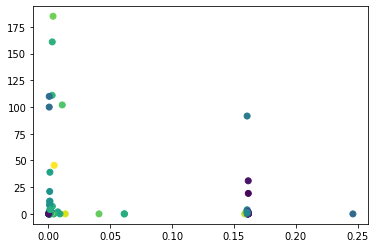

In [115]:
plt.figure()
plt.scatter(y_mean_, unknown_array_y, c=(y_std_ - y_std_.min()) / (y_std_.max() - y_std_.min()))
plt.show()

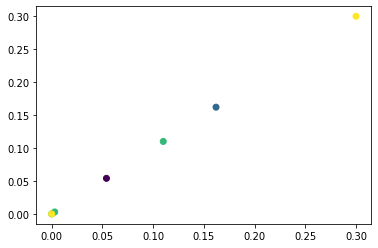

In [116]:
plt.figure()
plt.scatter(y_mean, y_train_array, c=(y_std - y_std.min()) / (y_std.max() - y_std.min()))
plt.show()

In [99]:
# apply whole dataset, use 80% 20% separate
df = pd.read_hdf('reduced_proteins_embeddings_meta.hdf', key='df')
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['wild_seq_2_embeddings']], axis=1)
df['wt1_wt2_concat'] = df.apply(concatenate_vectors, axis=1)
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors_mut(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['mutant_seq_embeddings']], axis=1)
df['wt1_mut_concat'] = df.apply(concatenate_vectors_mut, axis=1)
df

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat,wt1_mut_concat
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520..."
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520..."
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E9 DNase,Colicin E2 immunity protein,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MELKHSISDYTEAEFLEFVKKIARAEG

In [100]:
df['Affinity_mut_parsed'] = df['Affinity_mut_parsed'] * (10 ** 9)
df['Affinity_wt_parsed'] = df['Affinity_wt_parsed'] * (10 ** 9)
#max_molar = df[['Affinity_wt_parsed', 'Affinity_mut_parsed']].max().mean()
max_molar = df[['Affinity_wt_parsed']].median().max()
max_molar

0.164

In [104]:
# reduce the impact from outliers, if Kd > 10000., consider as weak binding, thus just put them as 10000
dt = df.copy()
dt.drop_duplicates(subset=['wild_seq_1', 'mutant_seq'], inplace=True)
for col in ['Affinity_mut_parsed', 'Affinity_wt_parsed']:
    dt.loc[dt[col] > 10000, col] = 10000.
# Drop rows where both columns contain 10000
dt = dt.drop(dt[(dt['Affinity_mut_parsed'] == 10000.) & (dt['Affinity_wt_parsed'] == 10000.)].index)
# Drop rows where one column is NaN and the other is 10000
dt = dt.drop(dt[((dt['Affinity_mut_parsed'].isna()) & (dt['Affinity_wt_parsed'] == 10000)) | ((dt['Affinity_wt_parsed'].isna()) & (dt['Affinity_mut_parsed'] == 10000))].index)

# Modify NaN in 'col1' when 'col2' is not 10000, and vice-versa
for col, other_col in [('Affinity_mut_parsed', 'Affinity_wt_parsed'), ('Affinity_wt_parsed', 'Affinity_mut_parsed')]:
    mask = (dt[col].isna()) & (dt[other_col] != 10000)
    dt.loc[mask, col] = 10000
dt

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat,wt1_mut_concat
0,1CSE_E_I,LI45G,0.05260,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
1,1CSE_E_I,LI45S,0.00833,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
2,1CSE_E_I,LI45P,102.00000,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
3,1CSE_E_I,LI45I,0.17200,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
4,1CSE_E_I,LI45D,1.92000,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,5UFQ_A_C,"DA12G,QC27R,KC59G",82.40000,6.40000,K-Ras,R11.1.6,MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...,ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...,-2.555287,"[[0.03184991, 0.003854431, -0.122885644, -0.02...","[[0.05051038, 0.027671836, -0.011607888, 0.014...","[[0.06724904, -0.04644814, -0.072430626, -0.10...","[[0.03184991, 0.003854431, -0.122885644, -0.02...","[[0.03184991, 0.003854431, -0.122885644, -0.02..."
2014,5TAR_A_B,"TA183A,KA184E",10000.00000,2300.00000,PDE delta,K-Ras,AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...,GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,-4.609509,"[[0.054286197, 0.015738036, 0.044642806, -0.04...","[[0.02156692, -0.015450158, -0.12526123, -0.00...","[[0.023280164, -0.011529279, -0.12501658, -0.0...","[[0.054286197, 0.015738036, 0.044642806, -0.04...","[[0.054286197, 0.015738036, 0.044642806, -0.04..."
2015,1KBH_A_B,QA3W,42.90000,34.00000,CREB NCBD,ACTR,PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...,EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK,EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK,-0.232511,"[[0.025925077, -0.061314803, 0.01449632, -0.01...","[[0.025865702, -0.04357512, 0.0019582573, -0.0...","[[0.0300

dt = df.copy()
# Convert the vectors to a string representation
dt['vectors_str'] = dt['wt1_wt2_concat'].apply(lambda x: str(list(x)))

# Remove duplicates based on vectors_str and floats columns
dt.drop_duplicates(subset=['vectors_str', 'Affinity_wt_parsed'], inplace=True, ignore_index=True)

# Optionally, drop the 'vectors_str' column and keep the original 'vectors' column
dt.drop(columns=['vectors_str'], inplace=True)
import ast
def str_to_array(s):
    return np.array(ast.literal_eval(s))

dt

In [105]:
splitting_index = int(0.8 * len(dt))
splitting_index

1215

In [106]:
from sklearn.model_selection import train_test_split

train_wt, test_wt = train_test_split(dt[['wt1_wt2_concat', 'Affinity_wt_parsed']], test_size=0.2, random_state=42)
x_train_wt_array = np.vstack(train_wt['wt1_wt2_concat'].to_numpy())
y_train_wt_array = np.vstack(train_wt['Affinity_wt_parsed'].to_numpy())
x_test_wt_array = np.vstack(test_wt['wt1_wt2_concat'].to_numpy())
y_test_wt_array = np.vstack(test_wt['Affinity_wt_parsed'].to_numpy())

In [113]:
train_wt

,wt1_wt2_concat,Affinity_wt_parsed
1660,"[[0.048999876, -0.012275338, -0.0051361225, 0....",0.0200
1645,"[[0.033420417, -0.051396016, 0.05942511, 0.013...",70.0000
1102,"[[-0.033333007, -0.038583428, 0.12762319, 0.01...",0.1640
1627,"[[0.048502233, -0.00020787268, -0.106788896, 0...",60.0000
1307,"[[-0.07031175, -0.13383733, 0.013853662, 0.140...",0.0179
...,...,...
1441,"[[-0.07031175, -0.13383733, 0.013853662, 0.140...",0.0179
1638,"[[0.03742235, -0.123825856, 0.013993897, 0.062...",0.0420
1119,"[[-0.07031175, -0.13383733, 0.013853662, 0.140...",0.0179
1950,"[[0.0073645534, -0.05058062, -0.09814369, 0.05...",3.2000


/opt/rh/rh-python38/root/usr/local/lib64/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:432: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


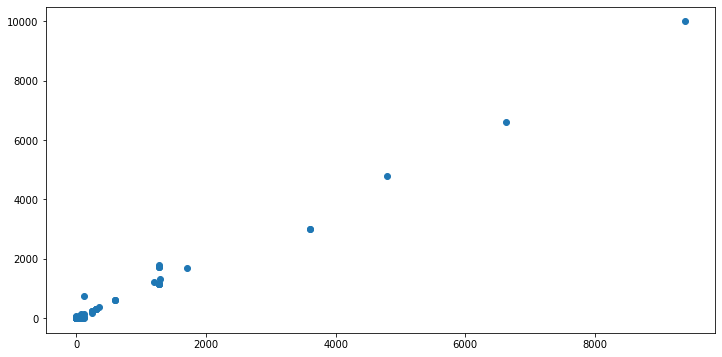

In [107]:
kernel_function = C(10000., 'fixed') * RBF(1., 'fixed')
gpr = GaussianProcessRegressor(kernel=kernel_function, random_state=0, normalize_y=True, copy_X_train=False)
n_samples, n_features = x_train_wt_array.shape
model = gpr.fit(x_train_wt_array, y_train_wt_array)
y_pred_wt, y_var_wt = gpr.predict(x_test_wt_array, return_std=True)
plt.figure()
plt.scatter(y_pred_wt, y_test_wt_array)
plt.show()

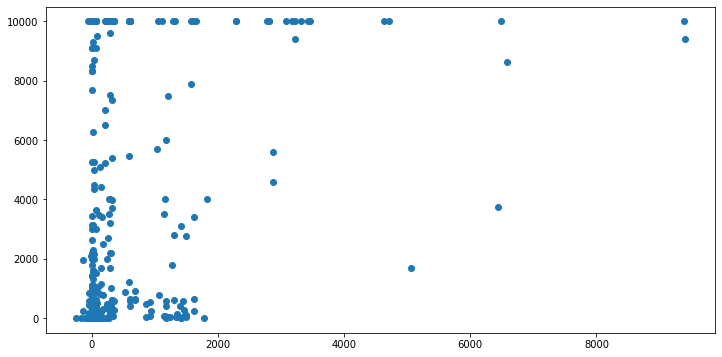

In [111]:
mut = dt[['wt1_mut_concat', 'Affinity_mut_parsed']]
unknown_array = np.vstack(mut['wt1_mut_concat'].to_numpy())
unknown_array_y = np.vstack(mut['Affinity_mut_parsed'].to_numpy())
y_pred_mut, y_var_mut = gpr.predict(unknown_array, return_std=True)
plt.figure()
plt.scatter(y_pred_mut, unknown_array_y)
plt.show()

In [90]:
# get training data
train_wt = dt[['wt1_wt2_concat', 'Affinity_wt_parsed']].iloc[:splitting_index]
test_wt = dt[['wt1_wt2_concat', 'Affinity_mut_parsed']].iloc[splitting_index:]
x_train_wt_array = np.vstack(train_wt['wt1_wt2_concat'].to_numpy())
pca_95 = PCA(n_components=28)
pca_results_95 = pca_95.fit_transform(x_train_wt_array)
y_train_wt_array = np.vstack(train_wt['Affinity_wt_parsed'].to_numpy())
x_test_wt_array = np.vstack(test_wt['wt1_wt2_concat'].to_numpy())
pca_95 = PCA(n_components=28)
pca_results_95_test = pca_95.fit_transform(x_test_wt_array)
y_test_wt_array = np.vstack(test_wt['Affinity_mut_parsed'].to_numpy())

In [87]:
from sklearn.model_selection import train_test_split

train_wt, test_wt = train_test_split(dt[['wt1_wt2_concat', 'Affinity_wt_parsed']], test_size=0.2, random_state=42)
x_train_wt_array = np.vstack(train_wt['wt1_wt2_concat'].to_numpy())
pca_95 = PCA(n_components=28)
pca_results_95 = pca_95.fit_transform(x_train_wt_array)
y_train_wt_array = np.vstack(train_wt['Affinity_wt_parsed'].to_numpy())
x_test_wt_array = np.vstack(test_wt['wt1_wt2_concat'].to_numpy())
pca_95 = PCA(n_components=28)
pca_results_95_test = pca_95.fit_transform(x_test_wt_array)
y_test_wt_array = np.vstack(test_wt['Affinity_wt_parsed'].to_numpy())

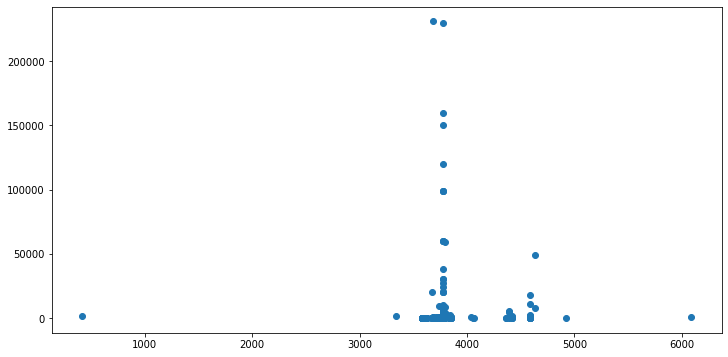

In [94]:
kernel_function = C(10000., 'fixed') * RBF(1., 'fixed')
gpr = GaussianProcessRegressor(kernel=kernel_function, random_state=0, normalize_y=True, copy_X_train=False)
n_samples, n_features = x_train_wt_array.shape
model = gpr.fit(pca_results_95, y_train_wt_array)
y_pred_wt, y_var_wt = gpr.predict(pca_results_95_test, return_std=True)
plt.figure()
plt.scatter(y_pred_wt, y_test_wt_array)
plt.show()

In [57]:
x_train_wt_array[0,:]

array([-0.03333301, -0.03858343,  0.12762319, ..., -0.14219783,
       -0.12137555,  0.07981922], dtype=float32)

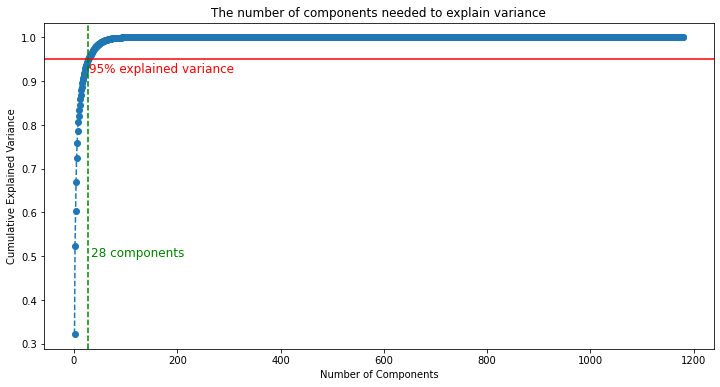

In [71]:
# select PCA elbow
from sklearn.decomposition import PCA
# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(x_train_wt_array)

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('The number of components needed to explain variance')

# Draw a horizontal line at 95% explained variance
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(30, 0.92, '95% explained variance', color = 'red', fontsize=12)

# Find the number of components for 95% variance
num_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
plt.axvline(x=num_components_95, color='g', linestyle='--')
plt.text(num_components_95 + 5, 0.5, f'{num_components_95} components', color = 'green', fontsize=12)

plt.show()

In [ ]:
pca_95 = PCA(n_components=95)
pca_results_95 = pca_95.fit_transform(x_train_wt_array)

In [53]:
mut = df[['wt1_mut_concat', 'specificity_score']]
unknown_array = np.vstack(mut['wt1_mut_concat'].to_numpy())
unknown_array_y = np.vstack(mut['specificity_score'].to_numpy())

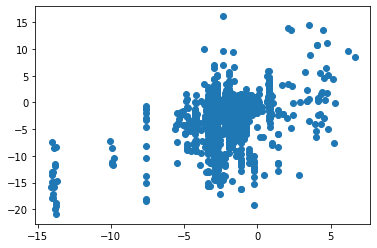

In [54]:
y_pred_mut, y_var_mut = gpr.predict(unknown_array, return_std=True)
plt.figure()
plt.scatter(y_pred_mut, unknown_array_y)
plt.show()

In [ ]:
# tsne reconstruct
from umap import UMAP
    um = UMAP(
        n_neighbors=15,
        min_dist=0.5,
        n_components=2,
        metric='euclidean',
    )
    X_umap = um.fit_transform(X)

    for name, coords in zip(
            [ 'pca', 'umap', 'tsne' ],
            [ X_pca, X_umap, X_tsne ],
    ):
        plt.figure()
        sns.scatterplot(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                        color='blue', alpha=0.1,)
        plt.scatter(x=coords[labels == 0, 0], y=coords[labels == 0, 1],
                    color='orange', alpha=1.0, marker='x', linewidths=10,)
        plt.savefig('figures/latent_scatter_{}_ypred_{}{}.png'
                    .format(name, regress_type, suffix), dpi=300)
        plt.close()

        plt.figure()
        plt.scatter(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                    c=ss.rankdata(var_unk_pred), alpha=0.1, cmap='coolwarm')
        plt.savefig('figures/latent_scatter_{}_var_{}{}.png'
                    .format(name, regress_type, suffix), dpi=300)
        plt.close()

        plt.figure()
        plt.scatter(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                    c=-acquisition, alpha=0.1, cmap='hot')
        plt.savefig('figures/latent_scatter_{}_acq_{}{}.png'
                    .format(name, regress_type, suffix), dpi=300)
        plt.close()

In [ ]:
kernel_function = C(max_molar, 'fixed') * RBF(1., 'fixed')
dt = df.copy()
# Convert the vectors to a string representation
dt['vectors_str'] = dt['wt1_wt2_concat'].apply(lambda x: str(list(x)))

# Remove duplicates based on vectors_str and floats columns
dt.drop_duplicates(subset=['vectors_str', 'Affinity_wt_parsed'], inplace=True, ignore_index=True)

# Optionally, drop the 'vectors_str' column and keep the original 'vectors' column
dt.drop(columns=['vectors_str'], inplace=True)
import ast
def str_to_array(s):
    return np.array(ast.literal_eval(s))


#dt['wt1_wt2_concat'] = dt['vectors_str'].apply(str_to_array)
dt
# get training data
x_train = dt[['wt1_wt2_concat', 'Affinity_wt_parsed']]
x_train
mut = df[['wt1_mut_concat', 'Affinity_mut_parsed']]
mut
x_train_array = np.vstack(x_train['wt1_wt2_concat'].to_numpy())
x_train_array
y_train_array = np.vstack(x_train['Affinity_wt_parsed'].to_numpy())
y_train_array
unknown_array = np.vstack(mut['wt1_mut_concat'].to_numpy())
unknown_array_y = np.vstack(mut['Affinity_mut_parsed'].to_numpy())
gpr = GaussianProcessRegressor(kernel=kernel_function, random_state=0, normalize_y=True, copy_X_train=False)
n_samples, n_features = x_train_array.shape
model = gpr.fit(x_train_array, y_train_array)
y_mean, y_std = gpr.predict(x_train_array, return_std=True)
#y_samples = gpr.sample_y(x_train_array, n_samples)
y_mean_, y_std_ = gpr.predict(unknown_array, return_std=True)


In [ ]:
for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim([-3, 3])

In [50]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 5, 100)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim([-3, 3])

Text(0.5, 1.0, 'Samples from posterior distribution')

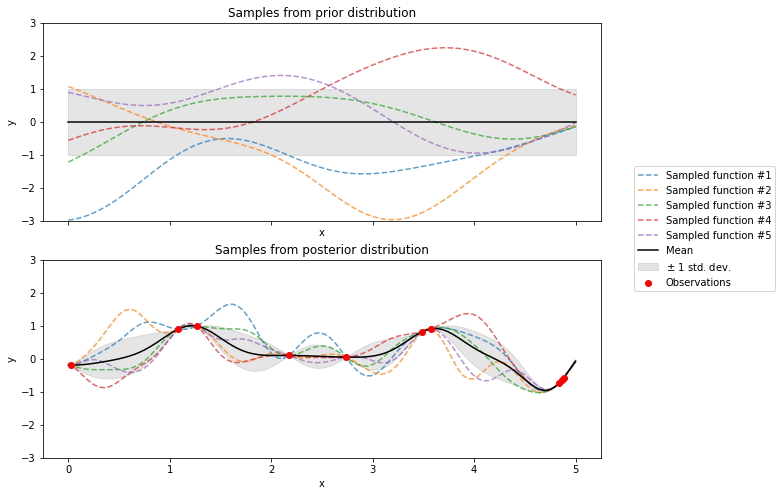

In [54]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
rng = np.random.RandomState(4)
X_train = rng.uniform(0, 5, 10).reshape(-1, 1)
y_train = np.sin((X_train[:, 0] - 2.5) ** 2)
n_samples = 5
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")
# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")